# STATE SPACE MODEL MATRICES

In [120]:
import sympy as sp

x,y,theta,psi,cte,v,w = sp.symbols("x y theta psi cte v w")

gs = sp.Matrix([[ sp.cos(theta)*v],
             [ sp.sin(theta)*v],
             [w],
             [-w],
             [ v*sp.sin(psi)]])

state = sp.Matrix([x,y,theta,psi,cte])

#A
gs.jacobian(state)

Matrix([
[0, 0, -v*sin(theta),          0, 0],
[0, 0,  v*cos(theta),          0, 0],
[0, 0,             0,          0, 0],
[0, 0,             0,          0, 0],
[0, 0,             0, v*cos(psi), 0]])

In [121]:
state = sp.Matrix([v,w])

#B
gs.jacobian(state)

Matrix([
[cos(theta),  0],
[sin(theta),  0],
[         0,  1],
[         0, -1],
[  sin(psi),  0]])

# PATH WAYPOINTS AS PARAMETRIZED CURVE

In [98]:
import numpy as np
from scipy.interpolate import interp1d

def compute_path_from_wp(start_xp, start_yp, step = 0.1):
    final_xp=[]
    final_yp=[]
    delta = step #[m]

    for idx in range(len(start_xp)-1):
        section_len = np.sum(np.sqrt(np.power(np.diff(start_xp[idx:idx+2]),2)+np.power(np.diff(start_yp[idx:idx+2]),2)))

        interp_range = np.linspace(0,1,np.floor(section_len/delta).astype(int))
        
        fx=interp1d(np.linspace(0,1,2),start_xp[idx:idx+2],kind=1)
        fy=interp1d(np.linspace(0,1,2),start_yp[idx:idx+2],kind=1)
        
        final_xp=np.append(final_xp,fx(interp_range))
        final_yp=np.append(final_yp,fy(interp_range))

    return np.vstack((final_xp,final_yp))

def get_nn_idx(state,path):

    dx = state[0]-path[0,:]
    dy = state[1]-path[1,:]
    dist = np.sqrt(dx**2 + dy**2)
    nn_idx = np.argmin(dist)

    try:
        v = [path[0,nn_idx+1] - path[0,nn_idx],
             path[1,nn_idx+1] - path[1,nn_idx]]   
        v /= np.linalg.norm(v)

        d = [path[0,nn_idx] - state[0],
             path[1,nn_idx] - state[1]]

        if np.dot(d,v) > 0:
            target_idx = nn_idx
        else:
            target_idx = nn_idx+1

    except IndexError as e:
        target_idx = nn_idx

    return target_idx

In [110]:
#define track
wp=np.array([0,5,6,10,11,15, 0,0,2,2,0,4]).reshape(2,-1)
track = compute_path_from_wp(wp[0,:],wp[1,:],step=0.5)

#vehicle state
state=[3.5,0.5,np.radians(30)]

#given vehicle pos find lookahead waypoints
nn_idx=get_nn_idx(state,track) #index ox closest wp
LOOKAHED=6
lk_wp=track[:,nn_idx:nn_idx+LOOKAHED]

#trasform lookahead waypoints to vehicle ref frame
dx = lk_wp[0,:] - state[0]
dy = lk_wp[1,:] - state[1]

wp_vehicle_frame = np.vstack(( dx * np.cos(-state[2]) - dy * np.sin(-state[2]),
                               dy * np.cos(-state[2]) + dx * np.sin(-state[2]) ))

#fit poly
coeff=np.polyfit(wp_vehicle_frame[0,:], wp_vehicle_frame[1,:], 3, rcond=None, full=False, w=None, cov=False)

def f(x,coeff):
    return coeff[0]*x**3+coeff[1]*x**2+coeff[2]*x**1+coeff[3]*x**0

In [111]:
coeff

array([-0.12829547,  0.96144073, -1.47313104, -0.47433648])

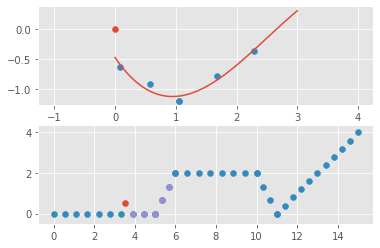

In [113]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

x=np.arange(0,3,0.001) #interp range of curve 

# VEHICLE REF FRAME
plt.subplot(2,1,1)
plt.scatter(0,0)
plt.scatter(wp_vehicle_frame[0,:],wp_vehicle_frame[1,:])
plt.plot(x,[f(xs,coeff) for xs in x])
plt.axis('equal')

# MAP REF FRAME
plt.subplot(2,1,2)
plt.scatter(state[0],state[1])
plt.scatter(track[0,:],track[1,:])
plt.scatter(track[0,nn_idx:nn_idx+LOOKAHED],track[1,nn_idx:nn_idx+LOOKAHED])
plt.axis('equal');

# COMPUTE ERRORS

* **crosstrack error** cte -> desired y-position - y-position of vehicle: this is the bias term of the fitted polynomial (road curve)
 
$
f = K_0 * x^3 + K_1 * x^2 + K_2 * x + K_3
$

Then for the origin cte = K_3
  
* **heading error** epsi ->  desired heading - heading of vehicle : is the inclination of  tangent to the  fitted polynomial (road curve)

The derivative of the fitted poly has the form

$
f' = 3.0 * K_0 * x^2 + 2.0 * K_1 * x + K_2
$

Then for the origin the equation of the tangent in the origin is $y=k2$   

epsi = -atan(K_2)

in general:

$
y_{desired} = f(px) \\
heading_{desired} = -atan(f`(px))
$

In [119]:
#for 0

cte=coeff[3]
epsi=-np.arctan(coeff[2])
print(cte)
print(np.degrees(epsi))

-0.47433647872956336
55.83031014720696


# ADD DELAY (for real time implementation)

It is necessary to take *actuation latency* into account: so instead of using the actual state as estimated, the delay factored in using the kinematic model

* $x_{delay} = 0.0 + v * dt$
* $y_{delay} = 0.0$
* $psi_{delay} = 0.0 + w * dt$
* $cte_{delay} = cte + v * sin(epsi) * dt$
* $epsi_{delay} = epsi - w * dt$

Note that the current position and heading is always 0; this is becouse the path is parametrized to vehicle reference frame